In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import openpyxl


In [3]:
file_path1 = 'dataset/Descriptif_patients.xlsx'
file_global_miss = 'dataset/radiomiques_global_cleaned.xlsx'
file_path3 = 'dataset/radiomiques_multislice_cleaned.xlsx'
file_global = 'dataset/Donnees_manquantes_reorganisees.xlsx'

# Liste des chemins de vos fichiers Excel
df_global = pd.read_excel(file_global, engine='openpyxl')

/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x1600 with 0 Axes>

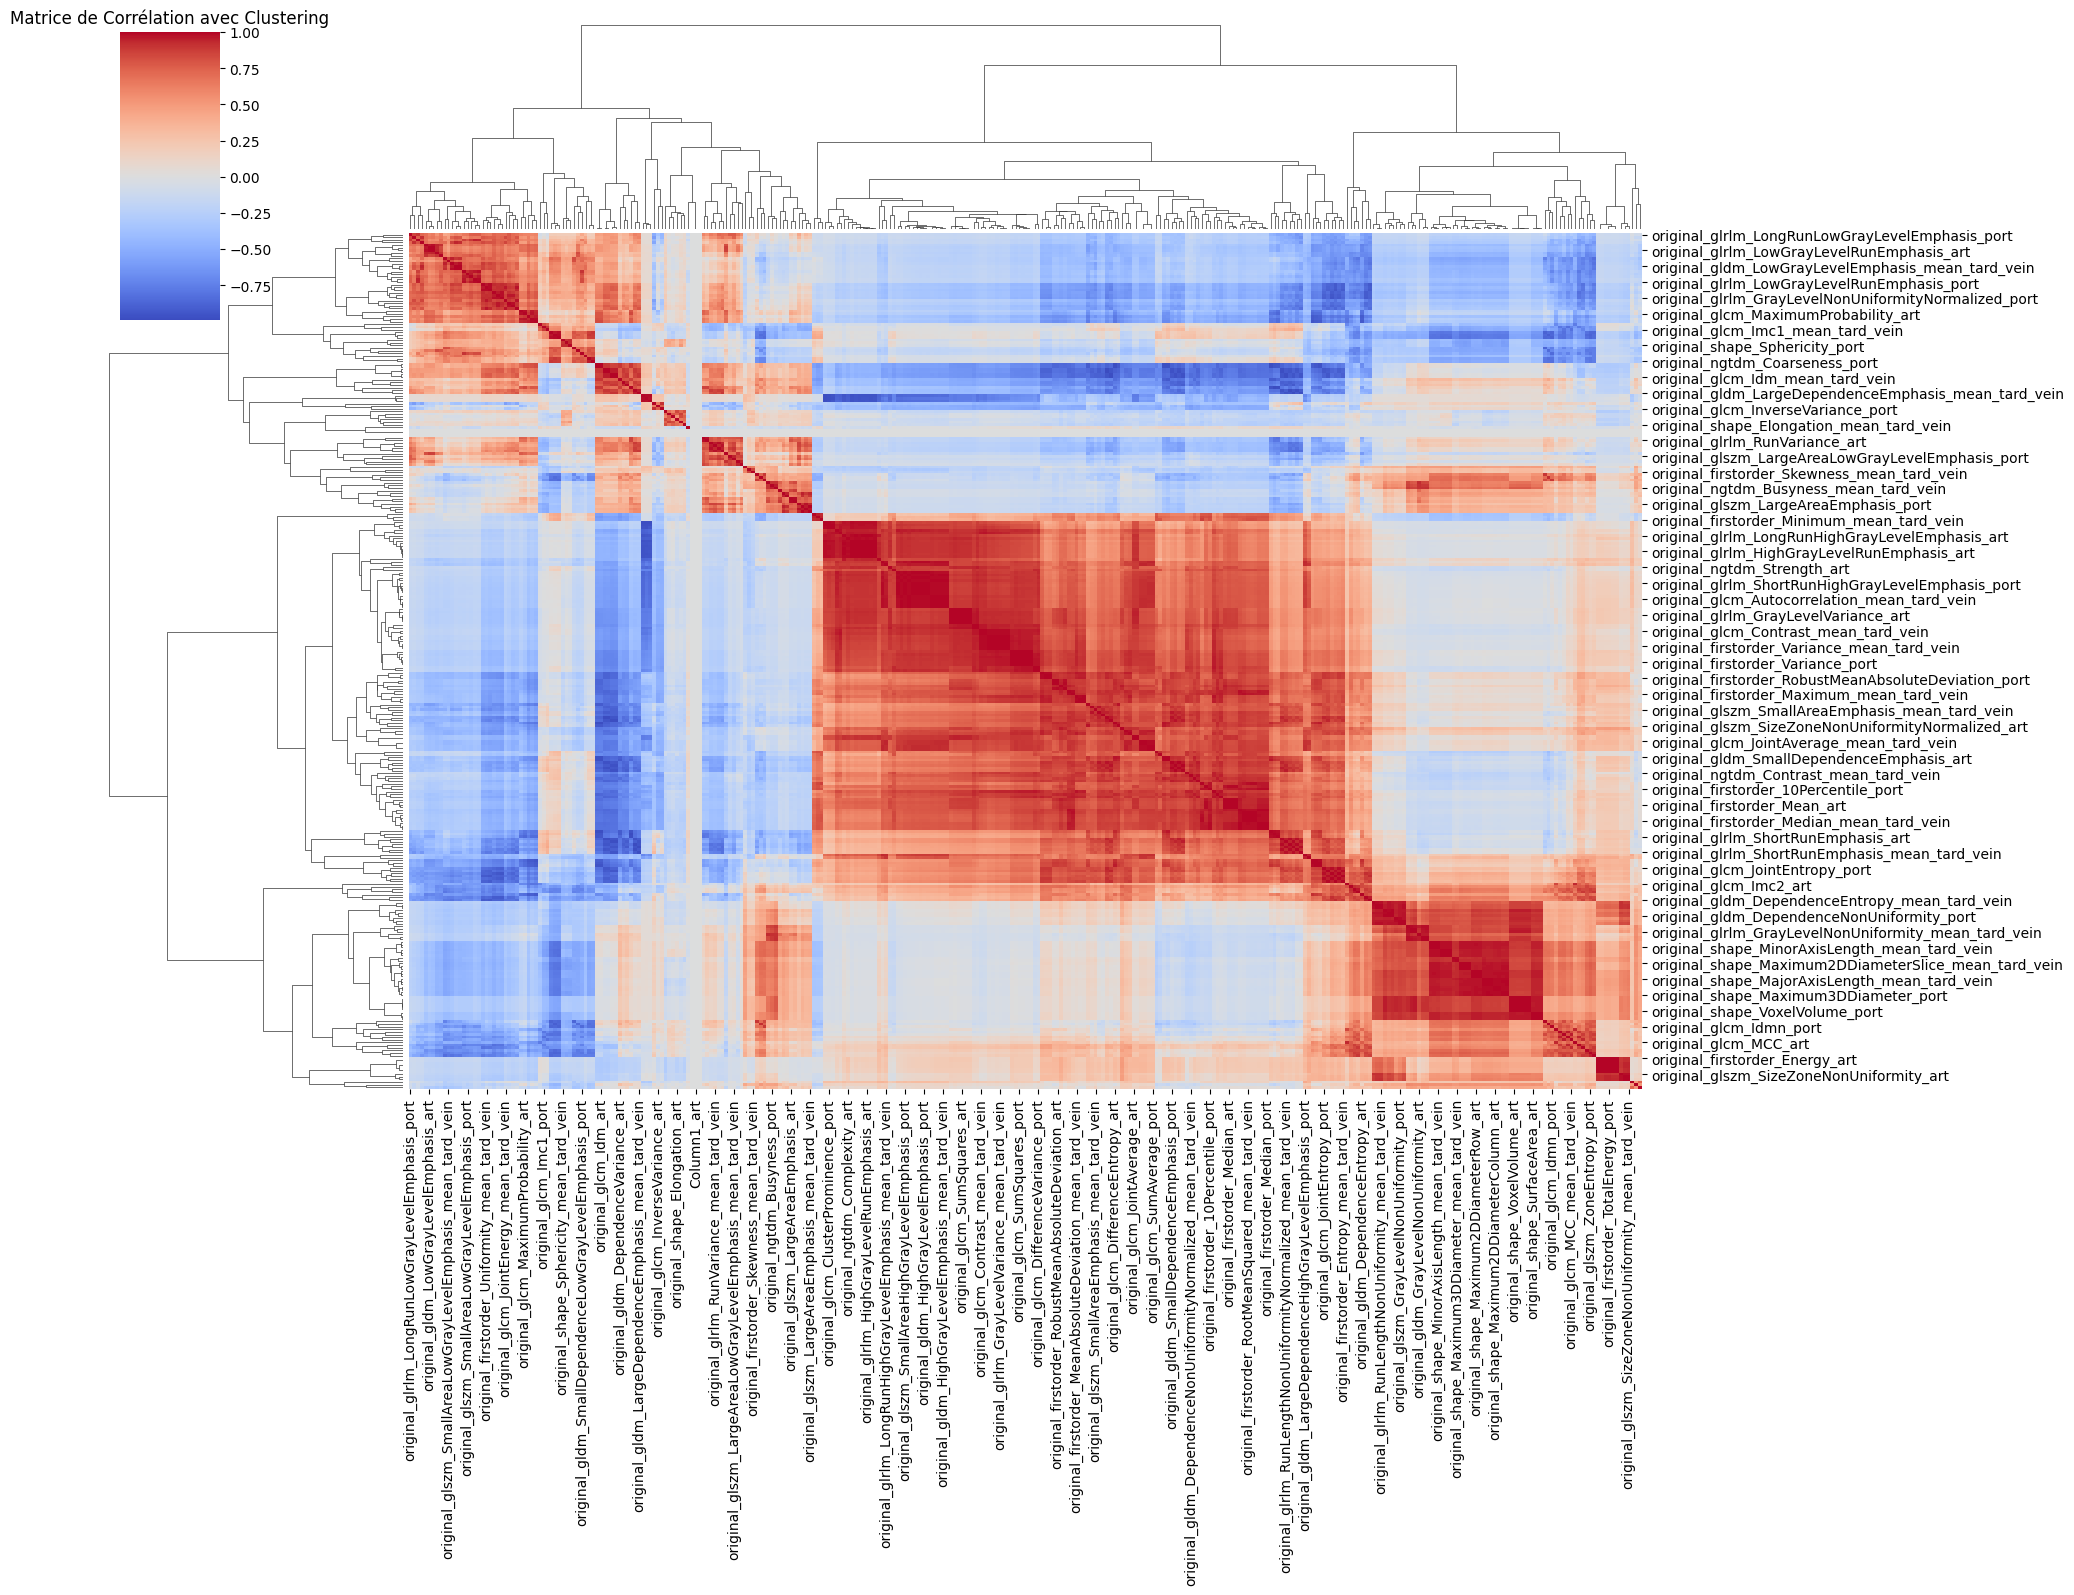

In [4]:
df_numeric = df_global.select_dtypes(include=[float, int]).iloc[:,:-2]
correlation_matrix = df_numeric.corr()

# Replace NaN and infinite values with zeros
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Filter to display only correlations above a certain threshold
threshold = 0.8
high_corr_var = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
filtered_corr_matrix = high_corr_var.dropna(axis=0, how='all').dropna(axis=1, how='all')

# # Plot the filtered heatmap
# plt.figure(figsize=(15, 12))
# sns.heatmap(filtered_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Filtered Correlation Matrix (Threshold = 0.8)')
# plt.show()

# Plot the clustered heatmap
plt.figure(figsize=(20, 16))
sns.clustermap(correlation_matrix, annot=False, cmap='coolwarm', figsize=(20, 16))
plt.title('Matrice de Corrélation avec Clustering')
plt.show()

Selected features after variance threshold:
Index(['Unnamed: 0', 'original_firstorder_10Percentile_art',
       'original_firstorder_90Percentile_art',
       'original_firstorder_Energy_art', 'original_firstorder_Entropy_art',
       'original_firstorder_InterquartileRange_art',
       'original_firstorder_Kurtosis_art', 'original_firstorder_Maximum_art',
       'original_firstorder_MeanAbsoluteDeviation_art',
       'original_firstorder_Mean_art',
       ...
       'original_glszm_HighGrayLevelZoneEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_SizeZoneNonUniformity_mean_tard_vein',
       'original_glszm_SmallAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_ZoneEntropy_mean_tard_vein',
       'original_glszm_ZoneVariance_mean_tard_vein',
       'original_ngtdm_Busyness_

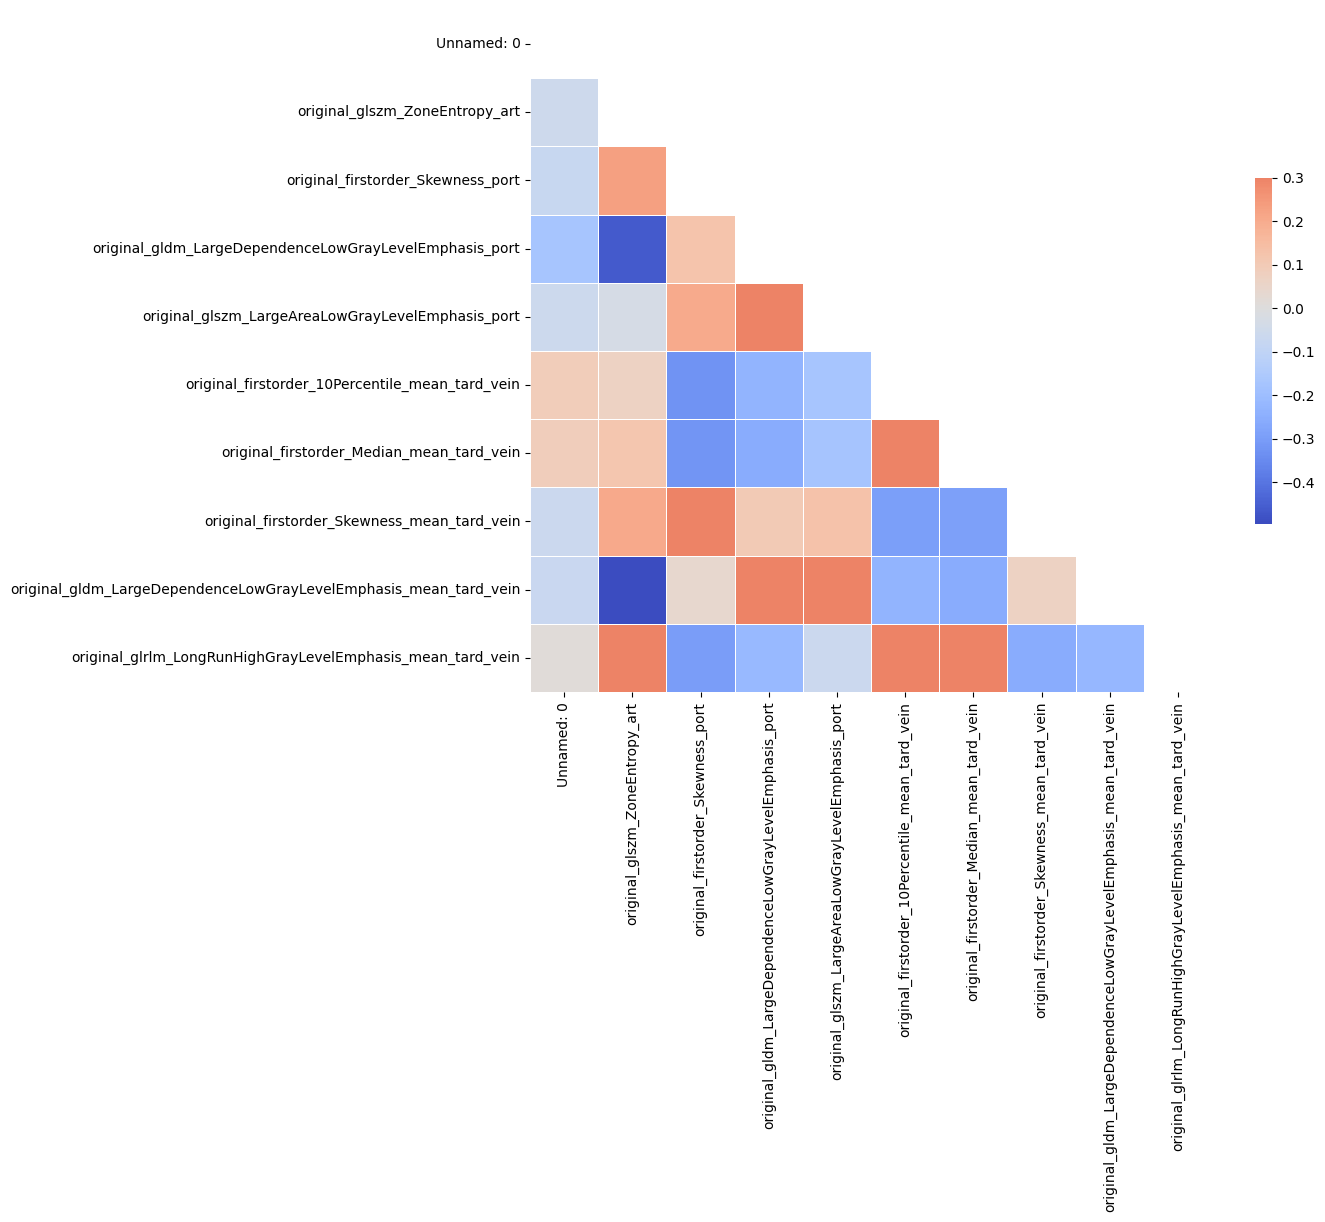

Features after Variance Threshold: Index(['Unnamed: 0', 'original_firstorder_10Percentile_art',
       'original_firstorder_90Percentile_art',
       'original_firstorder_Energy_art', 'original_firstorder_Entropy_art',
       'original_firstorder_InterquartileRange_art',
       'original_firstorder_Kurtosis_art', 'original_firstorder_Maximum_art',
       'original_firstorder_MeanAbsoluteDeviation_art',
       'original_firstorder_Mean_art',
       ...
       'original_glszm_HighGrayLevelZoneEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_SizeZoneNonUniformity_mean_tard_vein',
       'original_glszm_SmallAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_ZoneEntropy_mean_tard_vein',
       'original_glszm_ZoneVariance_mean_tard_vein',
       'original_ngtdm_Busyness_mean_tard

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set classe_name as the target variable
target = df_global['classe_name']


# 1. Variance Threshold
selector = VarianceThreshold(threshold=0.1)
df_reduced = selector.fit_transform(df_numeric)
selected_features = df_numeric.columns[selector.get_support(indices=True)]
df_reduced = pd.DataFrame(df_reduced, columns=selected_features)
print("Selected features after variance threshold:")
print(selected_features)

# Store features after variance threshold
features_after_variance_threshold = selected_features

# 2. Model-Based Selection (RFE)
model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=10)
fit = rfe.fit(df_reduced, target)
selected_features = df_reduced.columns[fit.support_]
df_reduced = df_reduced[selected_features]
print("Selected features after RFE:")
print(selected_features)

# Store features after RFE
features_after_rfe = selected_features

# 3. Correlation Analysis
corr_matrix = df_reduced.corr()
high_corr_vars = np.where(np.abs(corr_matrix) > 0.8)
high_corr_vars = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_vars) if x != y and x < y]
print("Highly correlated variables (above threshold):")
print(high_corr_vars)

# Dropping one of each pair of highly correlated features
to_drop = set([var[1] for var in high_corr_vars])
df_reduced = df_reduced.drop(columns=to_drop)
print("Final reduced DataFrame:")
print(df_reduced.head())

# Store final features after correlation analysis
final_selected_features = df_reduced.columns

# Visualize the final correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Output the most important features after each step
print("Features after Variance Threshold:", features_after_variance_threshold)
print("Features after RFE:", features_after_rfe)
print("Final selected features after Correlation Analysis:",final_selected_features)

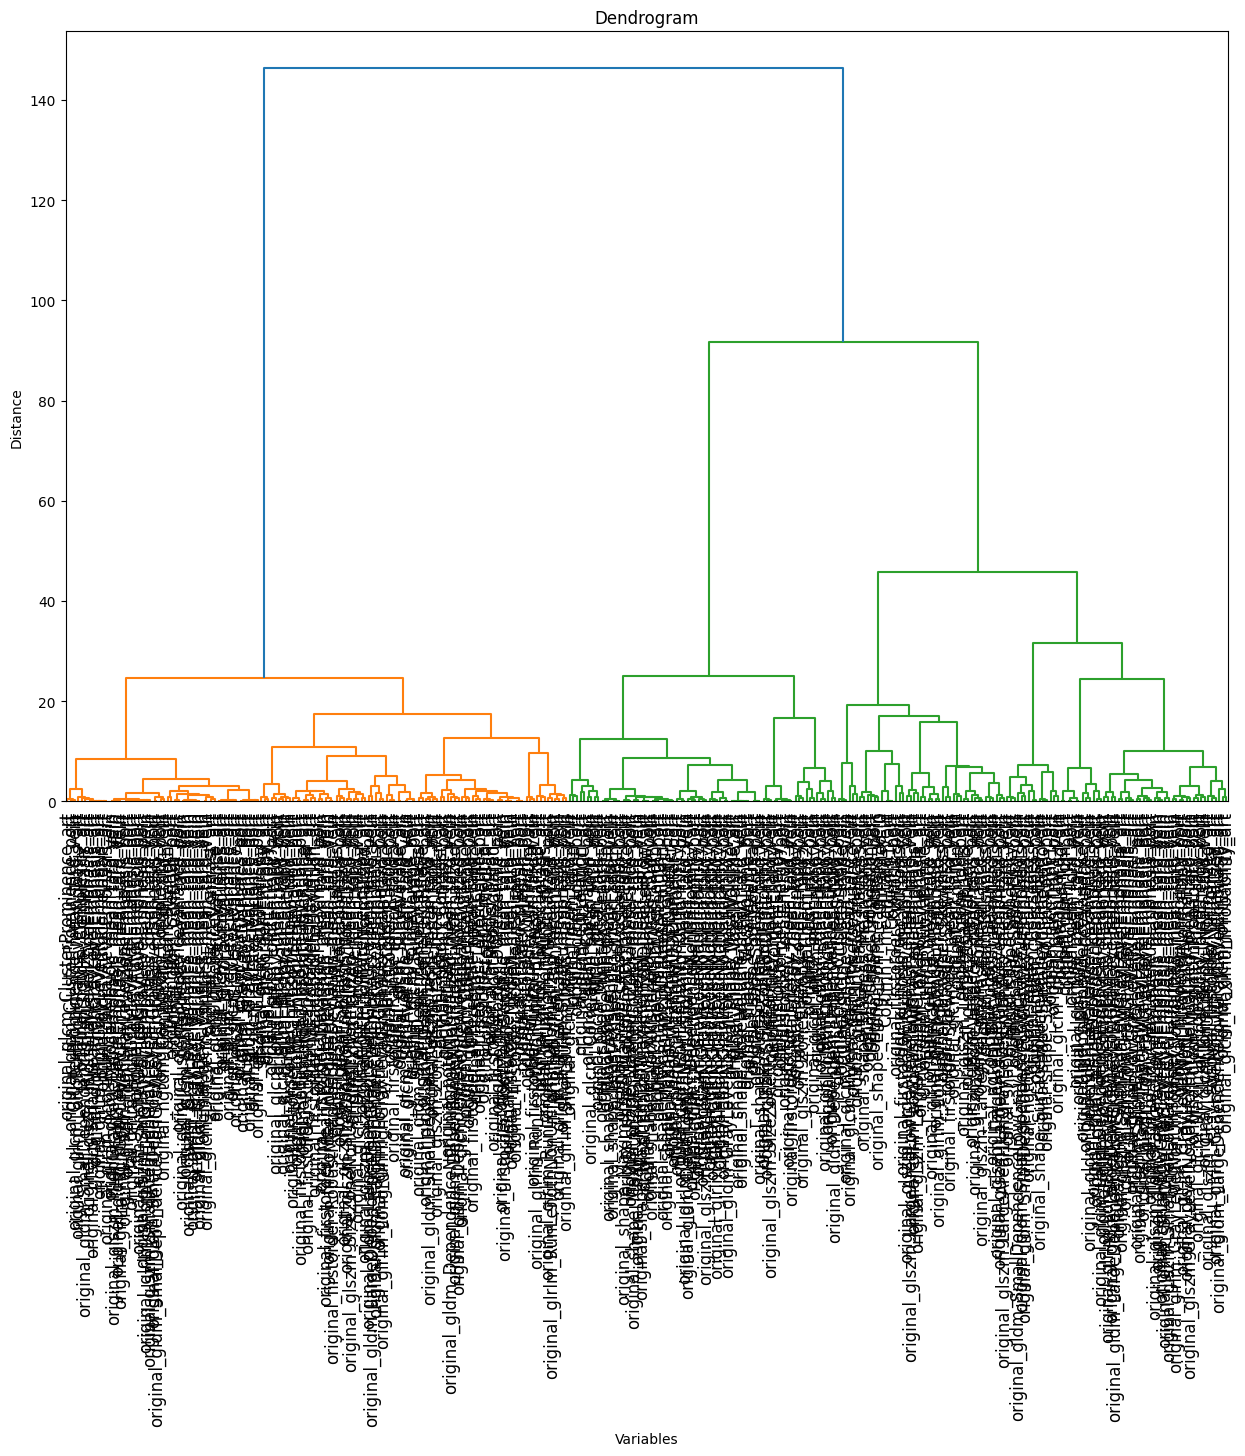

In [6]:
# Perform hierarchical clustering
Z = linkage(correlation_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.show()

In [7]:
# Choose a value for max_d
max_d = 10 # Adjust this value based on the dendrogram plot

# Form clusters by cutting the dendrogram at the chosen height
clusters = fcluster(Z, max_d, criterion='distance')

# Create a dictionary to hold the clusters
cluster_dict = {}
for idx, cluster_id in enumerate(clusters):
    variable = correlation_matrix.columns[idx]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(variable)

# Print the clusters
for cluster_id, variables in cluster_dict.items():
    print(f'Cluster {cluster_id}: {variables}')

Cluster 12: ['Unnamed: 0', 'original_firstorder_Kurtosis_art', 'Column1_art', 'original_firstorder_Kurtosis_port', 'Column1_port', 'original_firstorder_Kurtosis_mean_tard_vein', 'Column1_mean_tard_vein']
Cluster 4: ['original_firstorder_10Percentile_art', 'original_firstorder_90Percentile_art', 'original_firstorder_Mean_art', 'original_firstorder_Median_art', 'original_firstorder_RootMeanSquared_art', 'original_glcm_DifferenceAverage_art', 'original_gldm_DependenceNonUniformityNormalized_art', 'original_gldm_SmallDependenceEmphasis_art', 'original_glszm_ZonePercentage_art', 'original_ngtdm_Contrast_art', 'original_firstorder_10Percentile_port', 'original_firstorder_90Percentile_port', 'original_firstorder_Mean_port', 'original_firstorder_Median_port', 'original_firstorder_RootMeanSquared_port', 'original_glcm_DifferenceAverage_port', 'original_gldm_DependenceNonUniformityNormalized_port', 'original_gldm_SmallDependenceEmphasis_port', 'original_glszm_ZonePercentage_port', 'original_ngtd

PCA results for Cluster 12:
        PC1       PC2
0  0.690161 -1.746226
1  0.122452 -1.674031
2 -1.111374 -1.560522
3 -0.944150 -1.580496
4 -1.104720 -1.579753


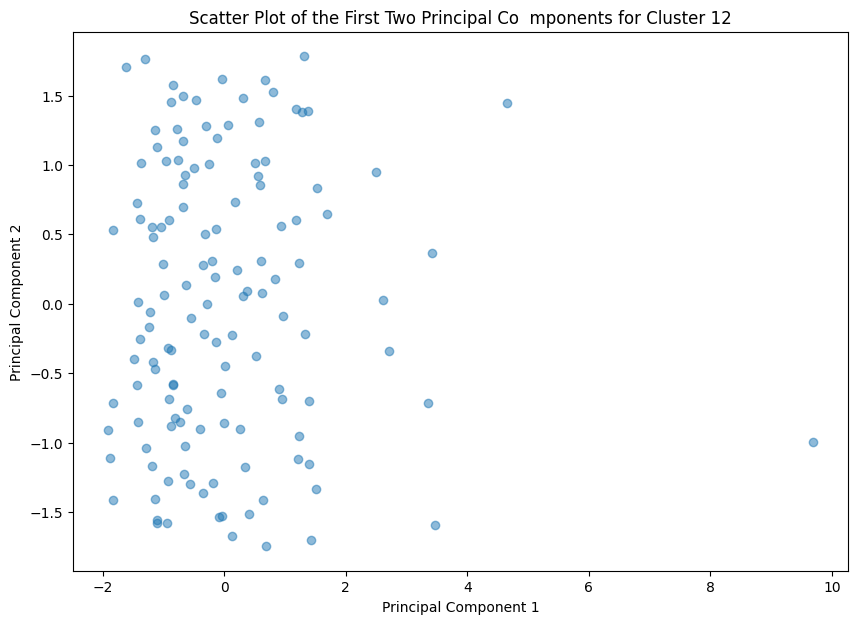

PCA results for Cluster 4:
        PC1       PC2
0 -1.229724 -0.786805
1 -1.707011  0.347550
2 -0.247444  0.217268
3 -2.756520 -0.508636
4 -2.782267 -0.633086


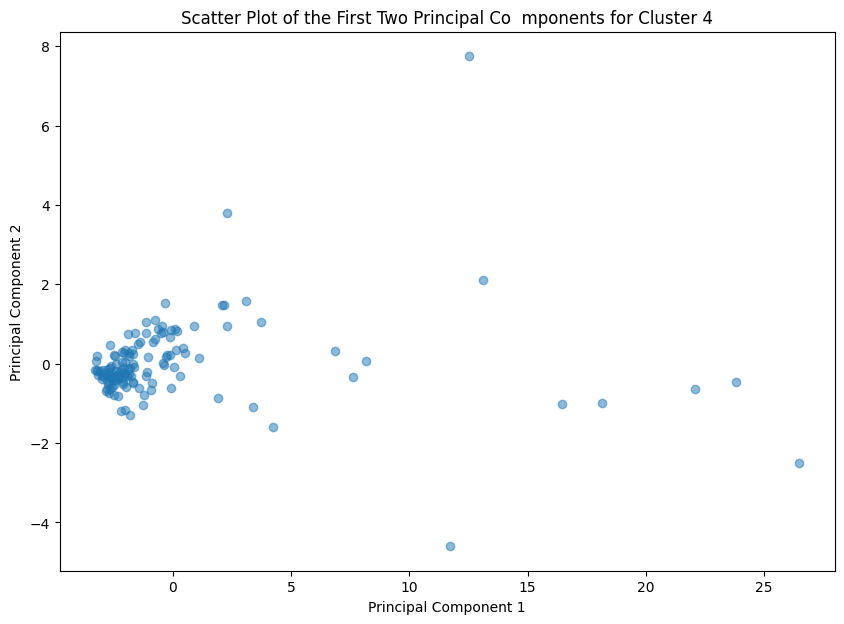

PCA results for Cluster 8:
        PC1       PC2
0 -0.603192 -0.118839
1 -0.737982 -0.100736
2 -0.734326 -0.100745
3 -0.166591 -0.094114
4 -0.691509 -0.097657


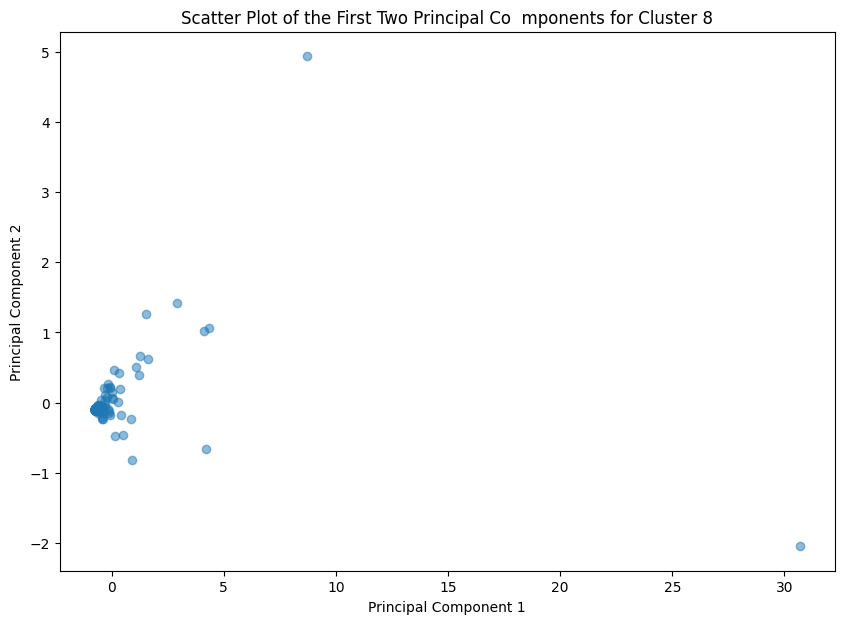

PCA results for Cluster 2:
        PC1       PC2
0  1.465248 -1.132757
1 -5.065303 -0.479647
2 -2.024163 -0.212584
3  0.468295 -0.016426
4 -2.843434  0.487101


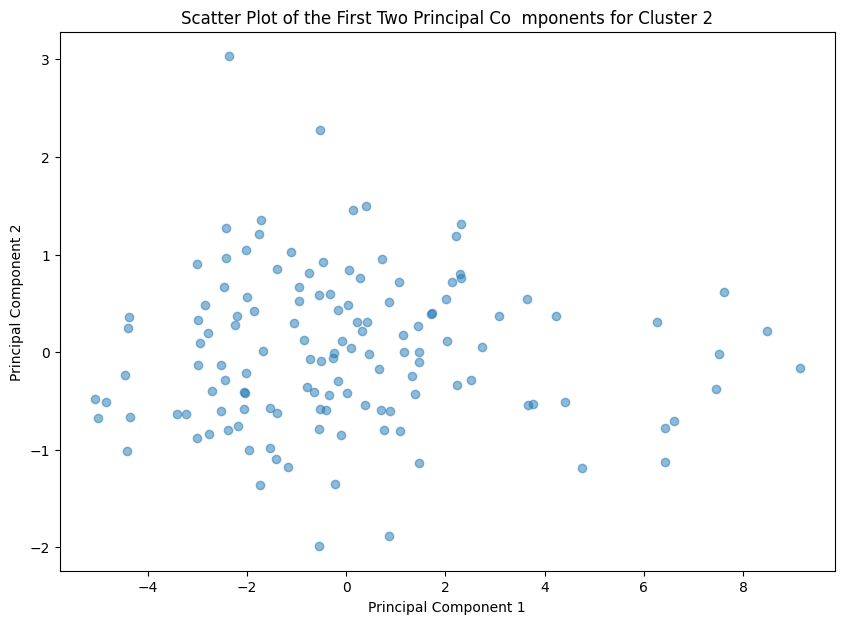

PCA results for Cluster 3:
        PC1       PC2
0 -0.635441 -0.215210
1 -3.174643 -0.615883
2 -2.625846 -0.192211
3 -1.286244  0.579225
4 -2.668820  0.337131


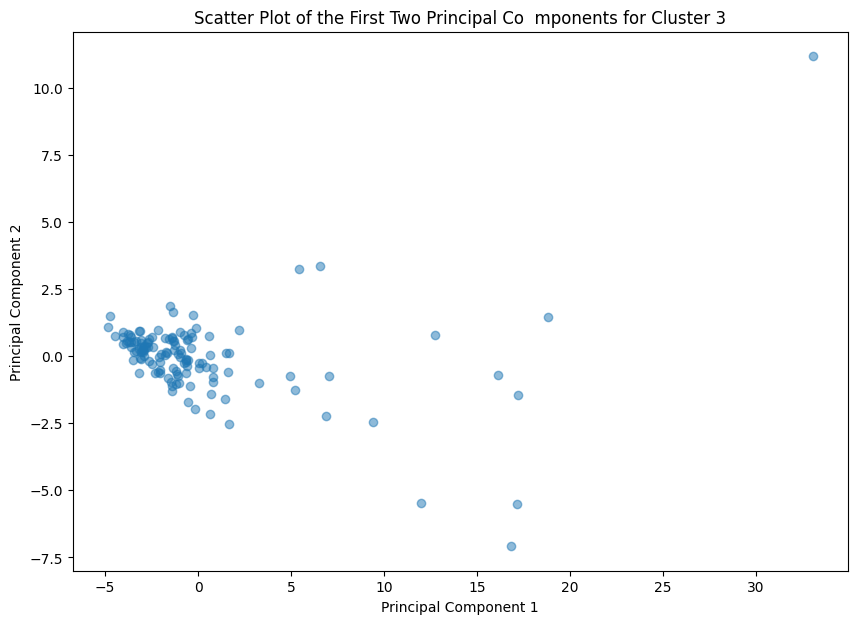

PCA results for Cluster 5:
        PC1       PC2
0 -0.391388  0.367732
1 -1.429175  0.791825
2  1.281763  0.230932
3 -2.979013  0.215379
4 -3.382747  0.870438


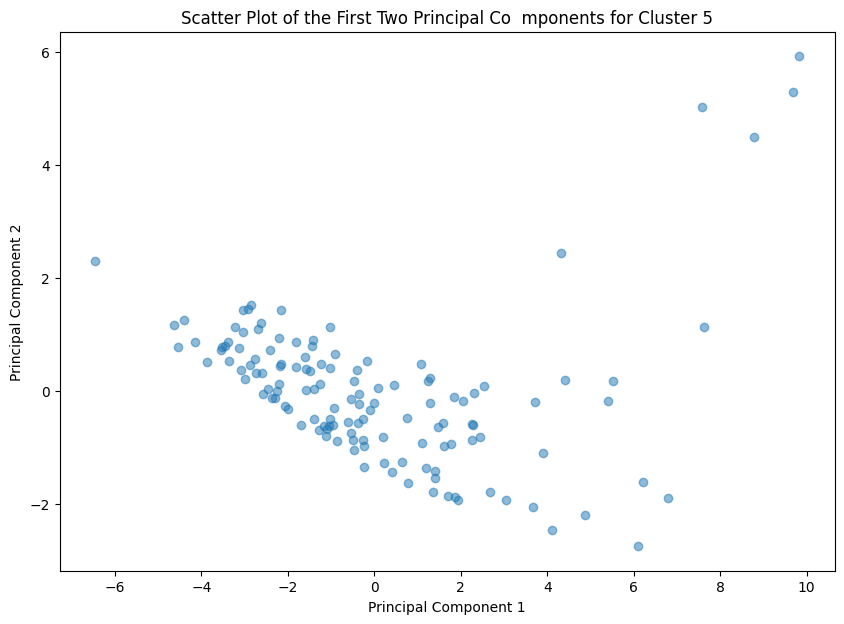

PCA results for Cluster 14:
        PC1       PC2
0  0.143617  3.313742
1 -2.102640 -0.688477
2 -2.655111 -1.575541
3  6.245431  0.232838
4  2.250945 -0.997082


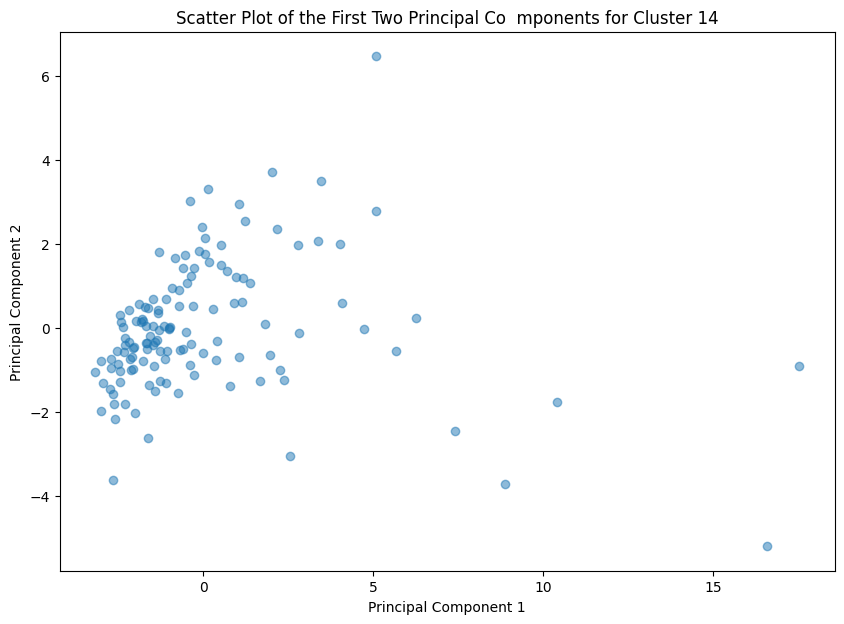

PCA results for Cluster 17:
         PC1       PC2
0  -2.609200 -1.339193
1  18.670615 -4.479857
2   2.783885 -1.740747
3  -2.670015 -0.119643
4   3.260165  0.241646


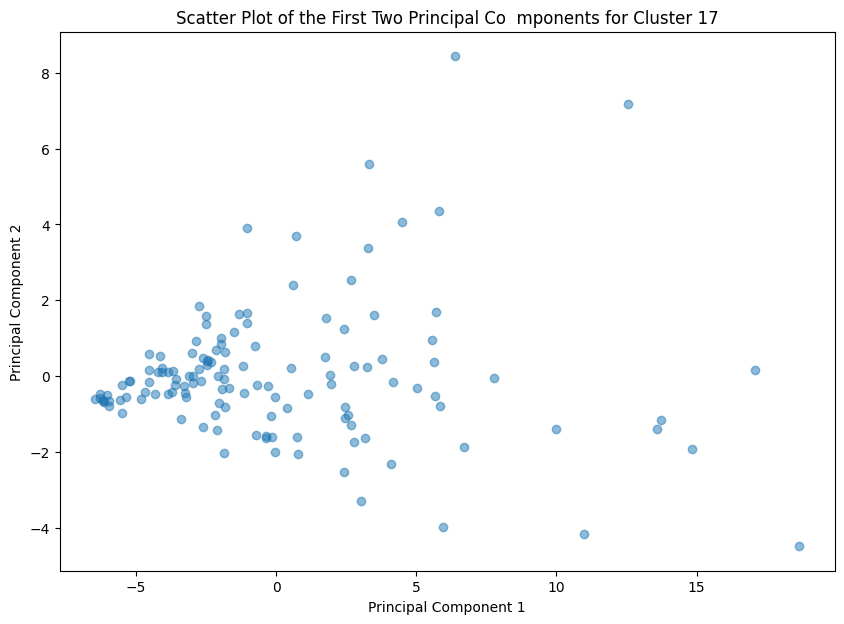

PCA results for Cluster 1:
        PC1       PC2
0 -1.033706 -0.212246
1 -1.879015 -0.315571
2 -1.754420 -0.295306
3 -1.424997 -0.254473
4 -1.735803 -0.429381


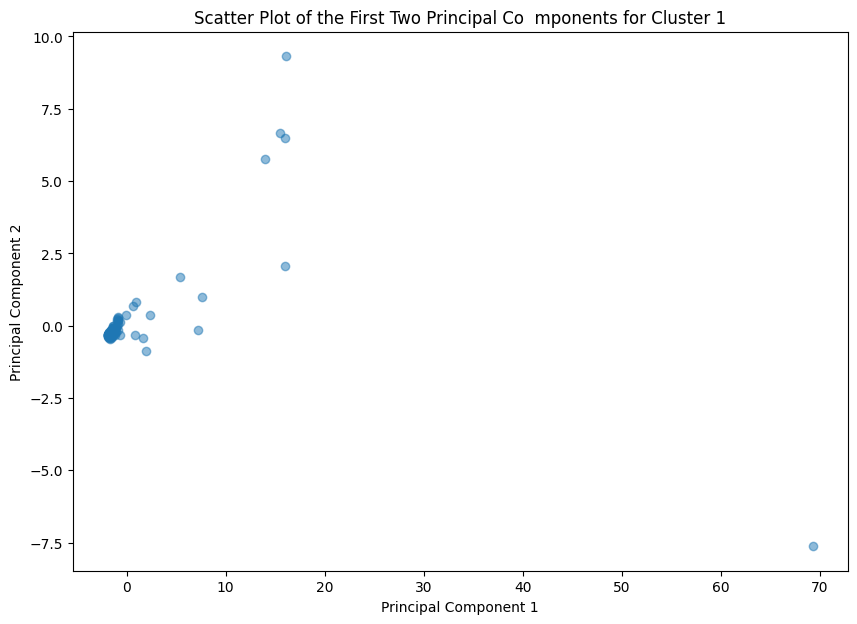

PCA results for Cluster 11:
        PC1       PC2
0 -0.733188  0.202675
1  2.571721 -0.007361
2  1.205696 -0.423678
3 -1.231837 -0.112143
4 -1.934864  0.303018


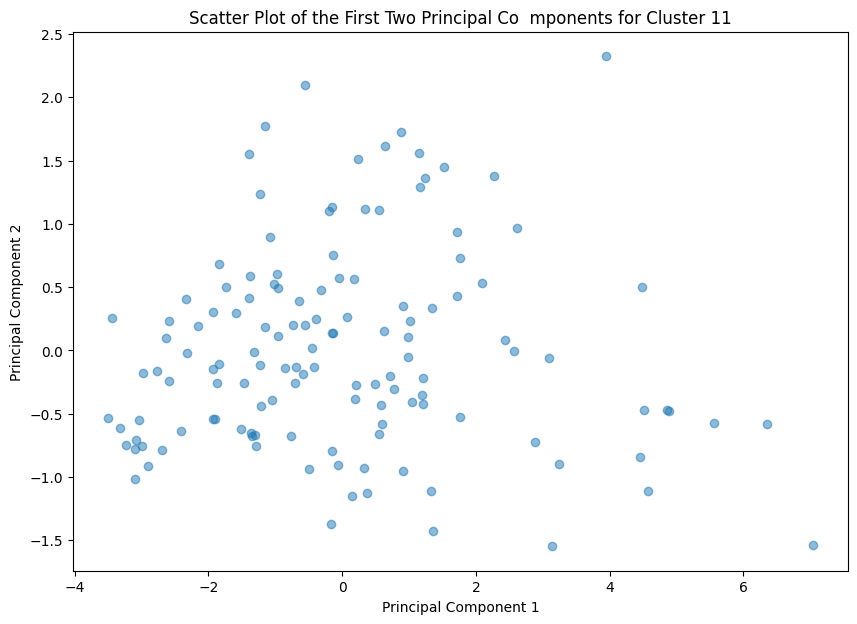

PCA results for Cluster 7:
        PC1       PC2
0 -1.464301 -0.848307
1 -5.185359  1.795695
2 -4.882171  1.550635
3  7.585743 -2.042151
4 -1.357833 -0.885116


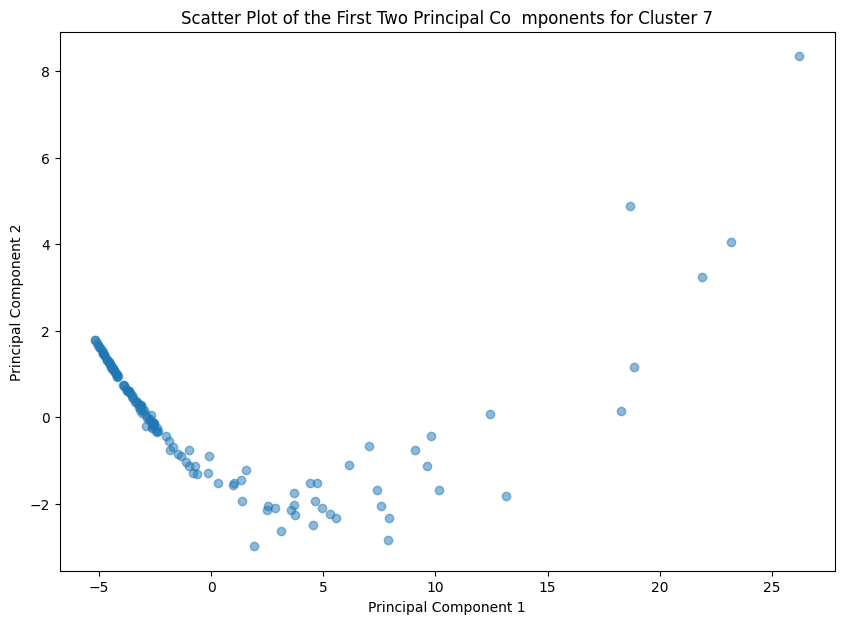

PCA results for Cluster 15:
         PC1       PC2
0  -2.523236 -0.499870
1  12.005976  2.276400
2   6.134721  0.362481
3  -3.602466 -2.218113
4  -1.442559  0.559369


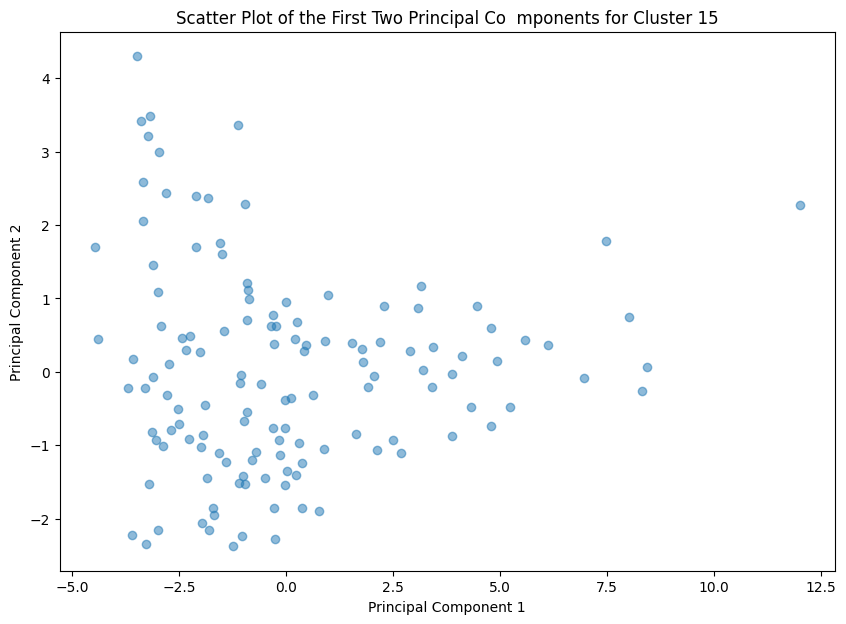

PCA results for Cluster 10:
        PC1       PC2
0 -0.824884  0.746947
1  0.683855 -1.169936
2 -0.938852  1.045935
3  0.184890 -0.483482
4  0.764012 -1.229353


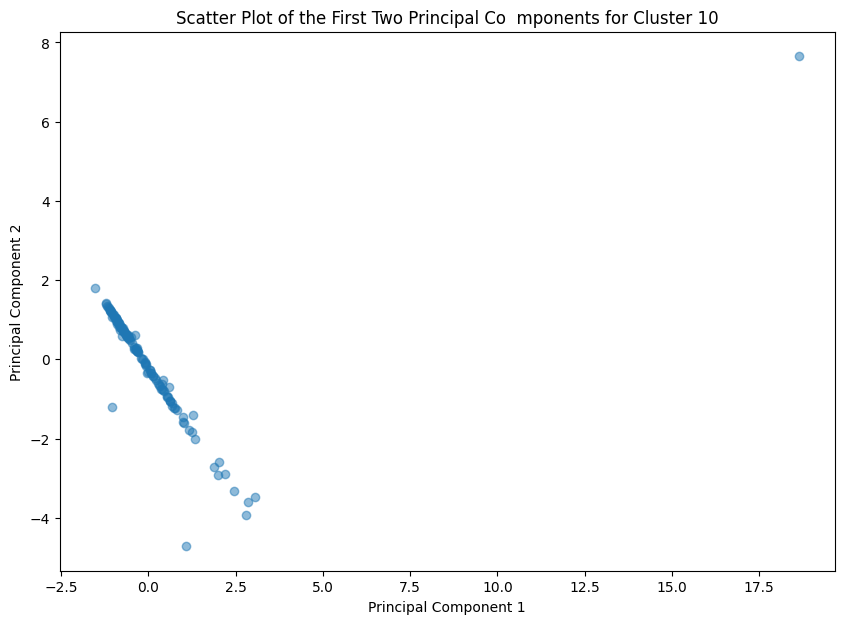

PCA results for Cluster 6:
         PC1       PC2
0  -3.932591 -0.971713
1  10.236266  1.177462
2   3.402392 -2.548977
3  -3.826509 -0.820891
4   0.116803  0.866917


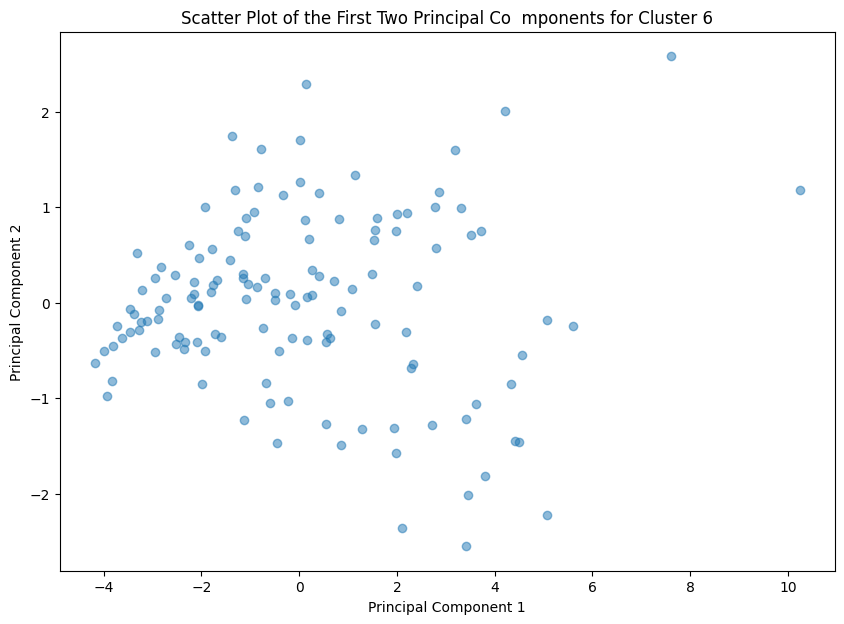

PCA results for Cluster 16:
        PC1       PC2
0 -0.542232 -0.831210
1 -2.419368 -1.530196
2  0.002293  0.644751
3 -3.065808  0.406996
4 -3.783655  0.624669


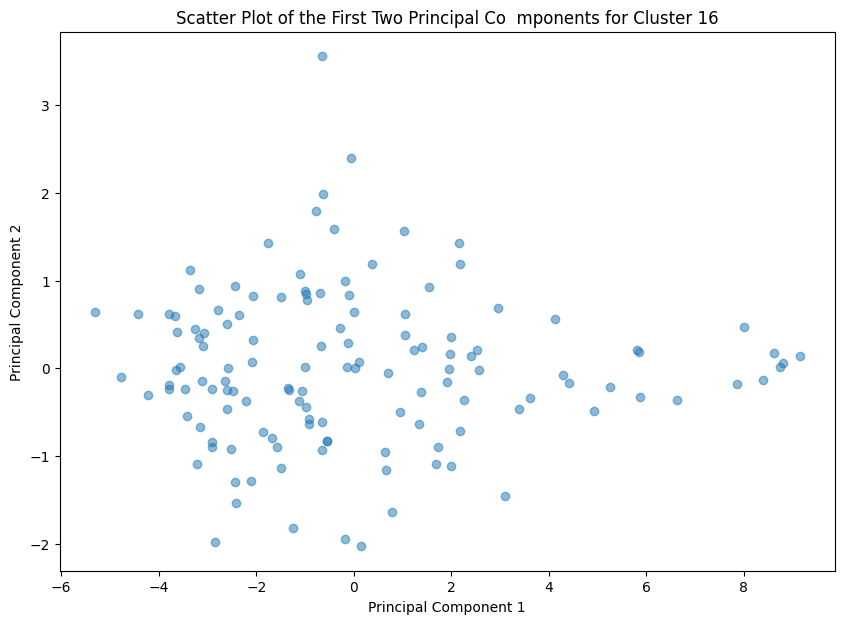

PCA results for Cluster 9:
         PC1       PC2
0  -3.957899 -1.006078
1  10.161783  0.150822
2   4.739924 -1.428603
3  -4.218662 -0.184696
4   1.312951  0.711286


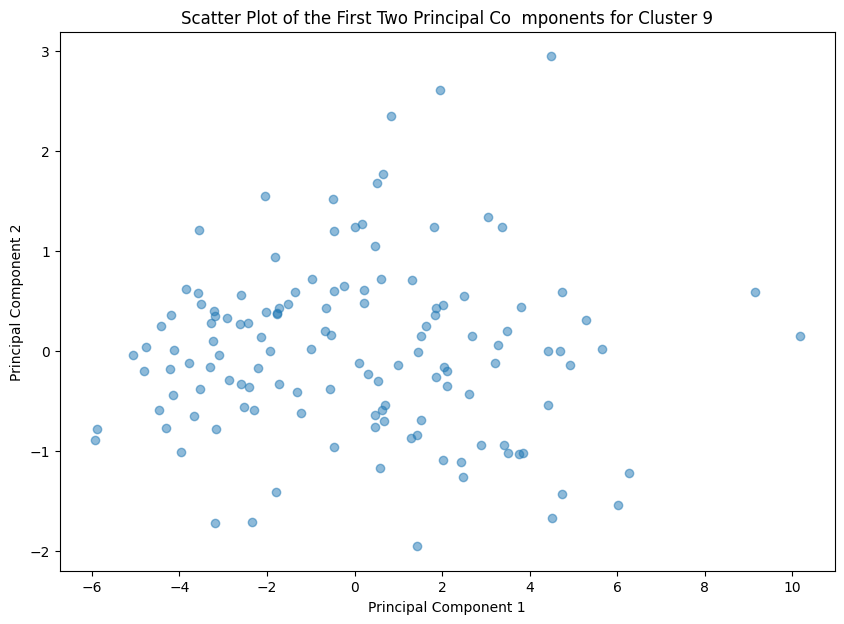

PCA results for Cluster 13:
        PC1       PC2
0 -0.761727 -0.260510
1 -0.700846  0.023372
2 -1.564459  0.489199
3  2.664834 -0.868771
4  3.473486 -0.807641


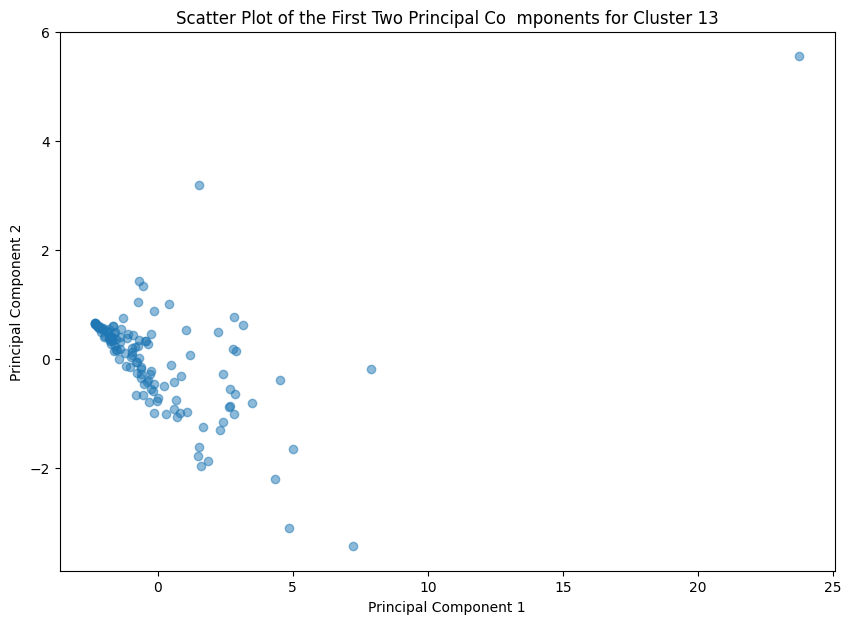

In [8]:


# Function to apply PCA to a cluster of variables
def apply_pca_to_cluster(df, cluster_variables):
    if len(cluster_variables) < 2:
        print(f"Cluster {cluster_variables} has less than 2 variables, skipping PCA.")
        return None
    
    # Select the cluster variables
    cluster_data = df[cluster_variables]
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Apply PCA
    pca = PCA(n_components=2)  # Retain only the first 2 components for visualization
    principal_components = pca.fit_transform(scaled_data)
    
    # Convert PCA results to a DataFrame
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    
    return pca_df

# Apply PCA to each cluster and store the results in a dictionary
pca_results = {}
for cluster_id, variables in cluster_dict.items():
    pca_df = apply_pca_to_cluster(df_numeric, variables)
    if pca_df is not None:
        pca_results[cluster_id] = pca_df
        print(f'PCA results for Cluster {cluster_id}:')
        print(pca_df.head())
        
        # Visualize the PCA results
        plt.figure(figsize=(10, 7))
        plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
        plt.title(f'Scatter Plot of the First Two Principal Co  mponents for Cluster {cluster_id}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()
        
pca_combined = pd.concat(pca_results.values(), axis=1)

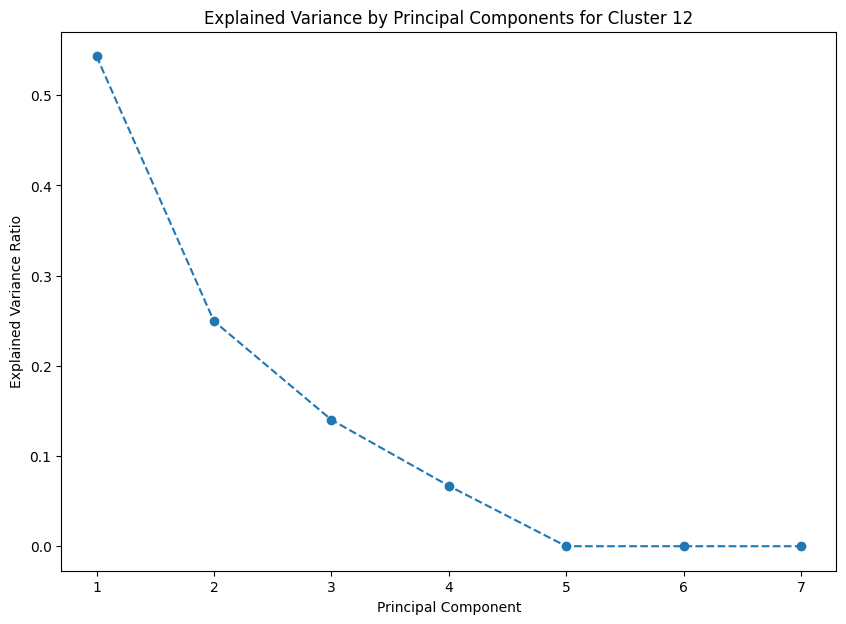

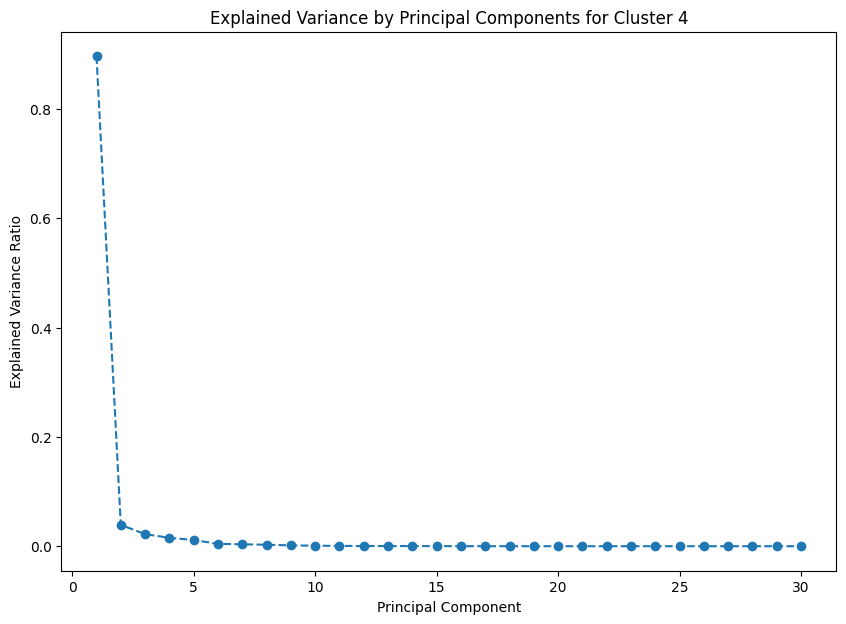

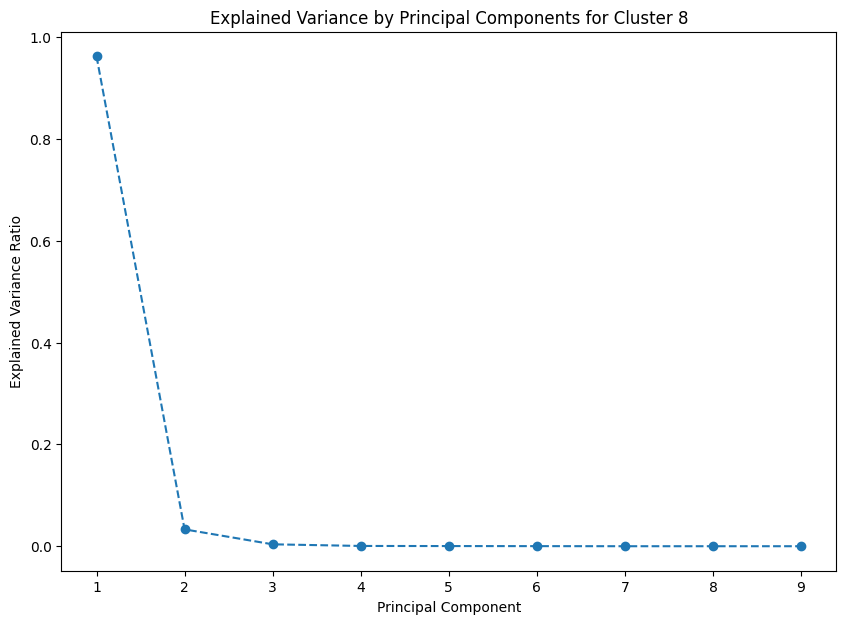

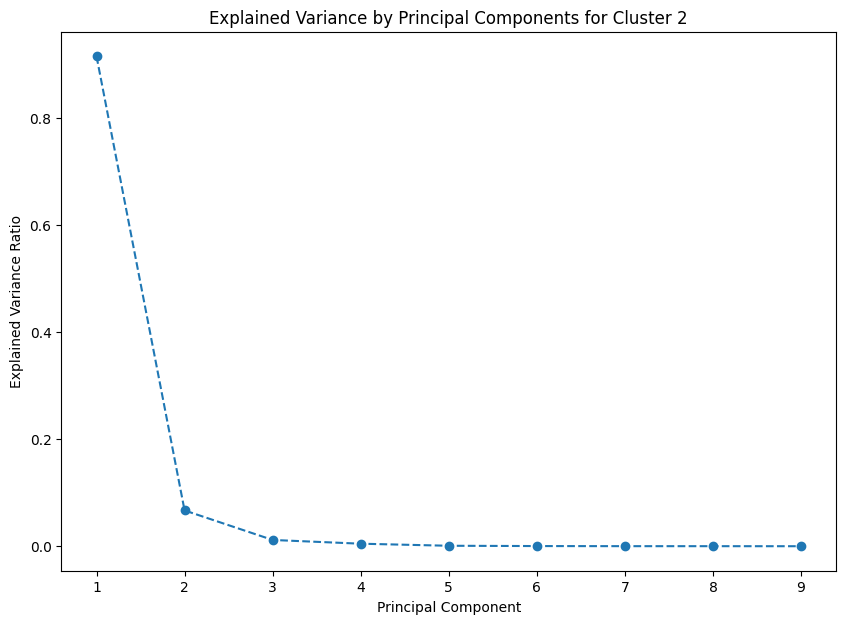

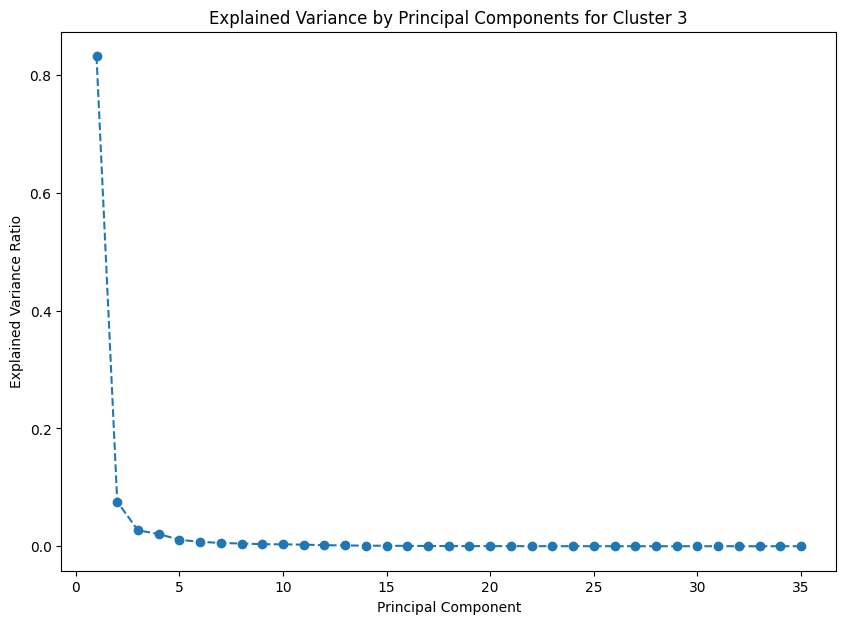

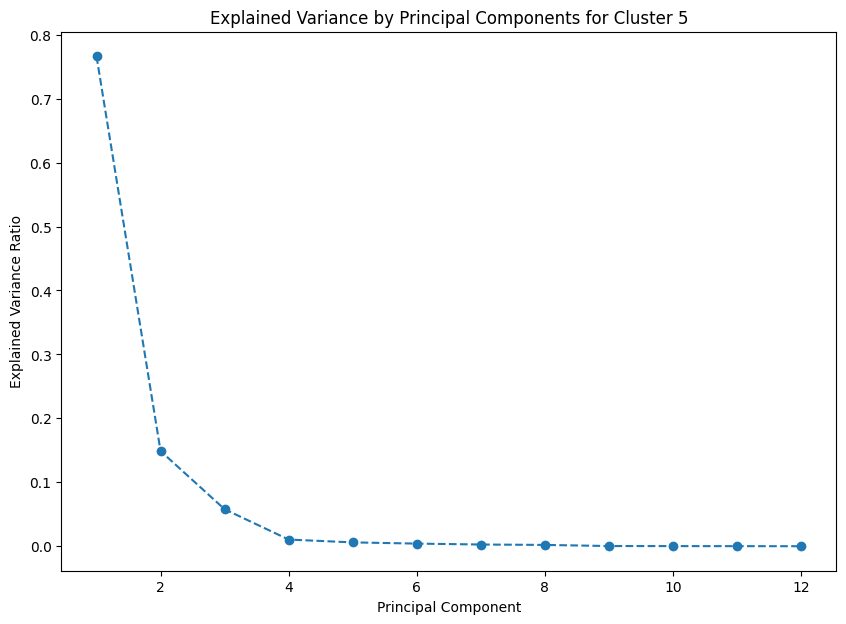

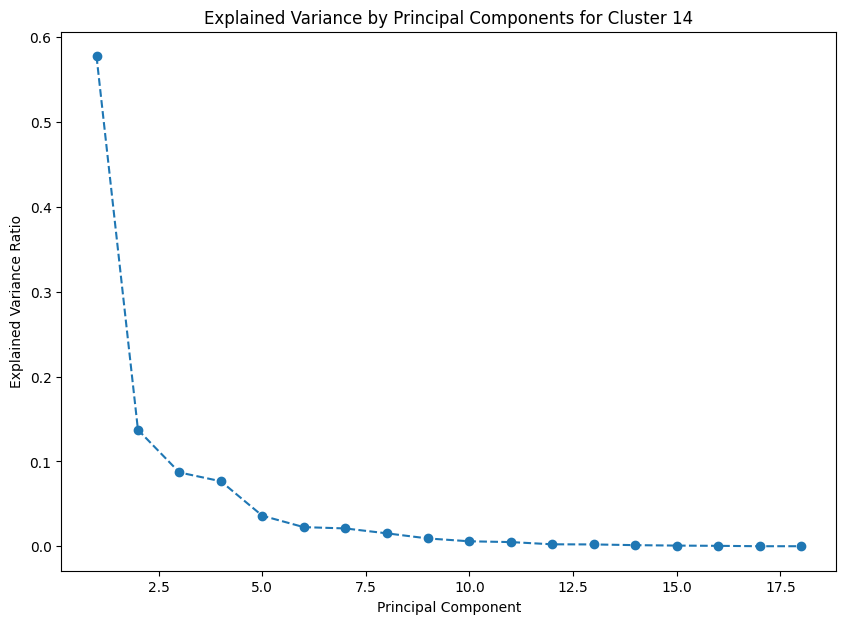

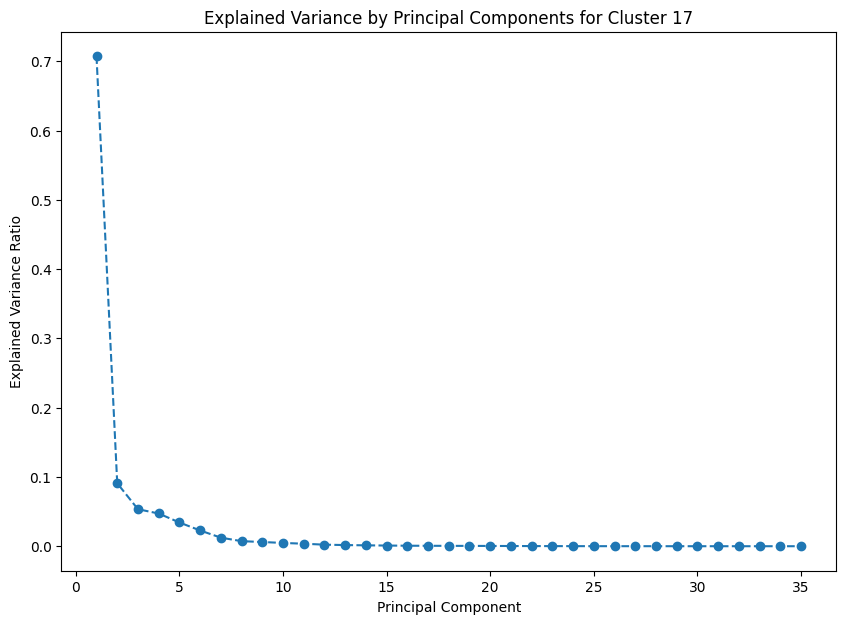

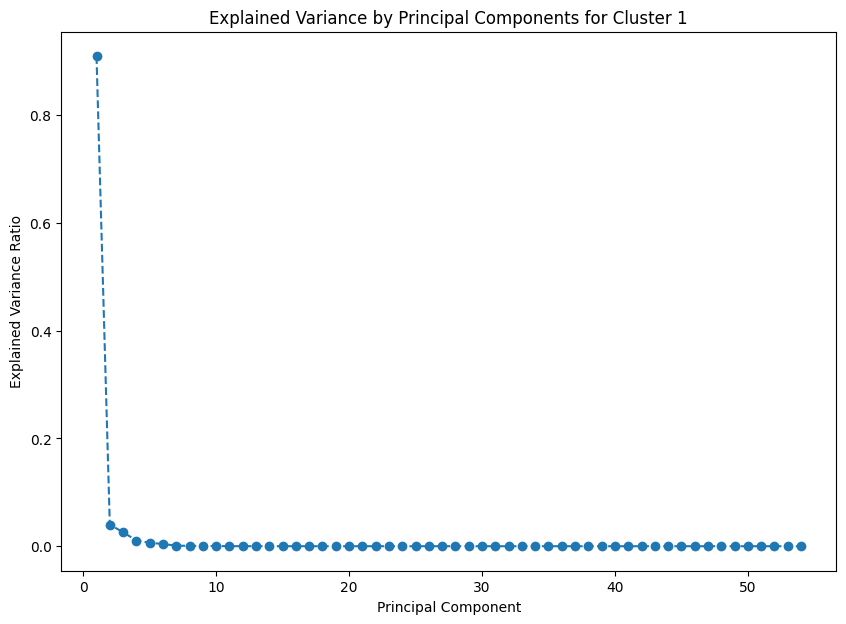

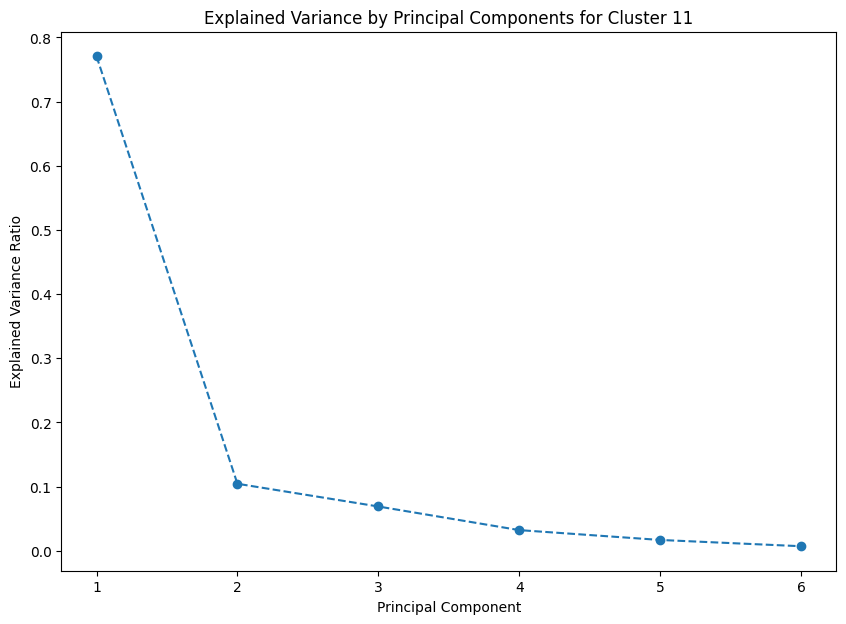

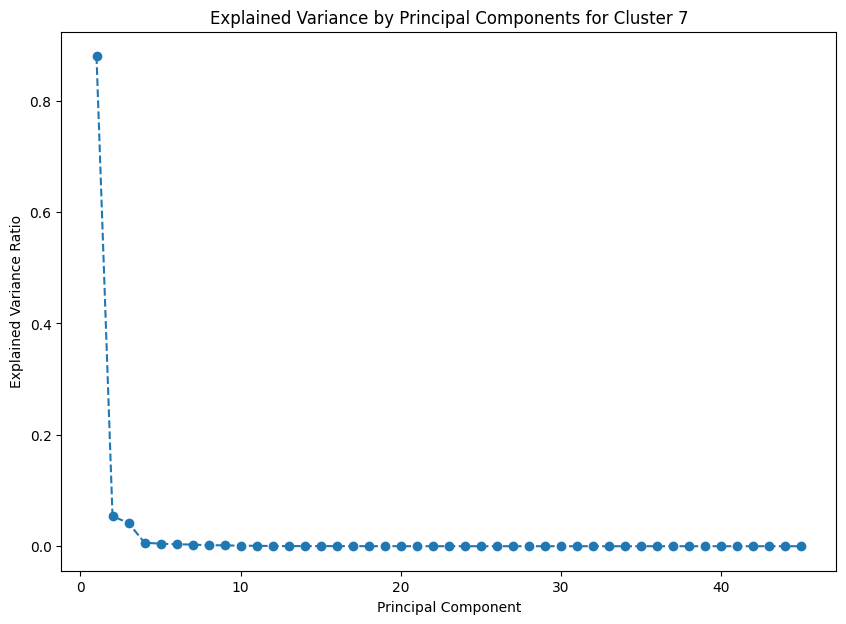

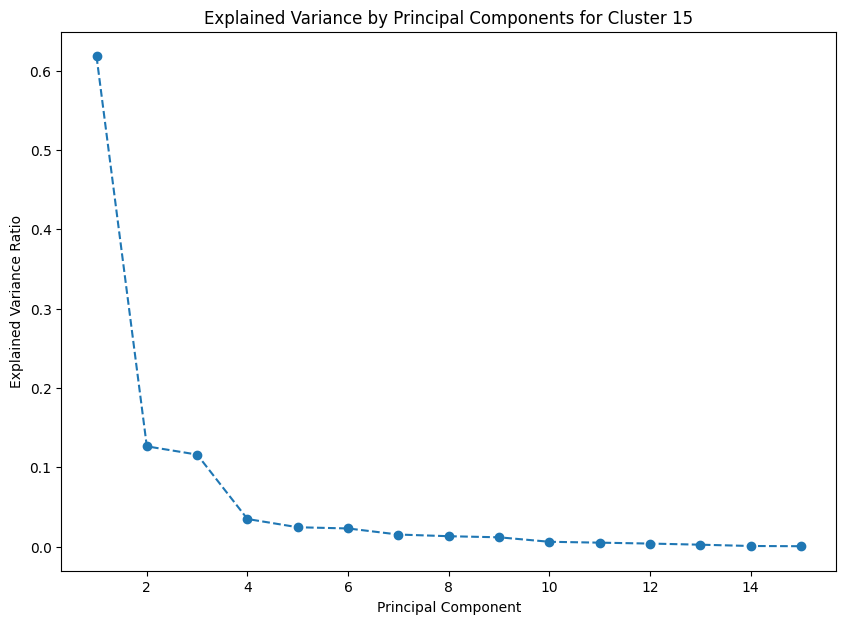

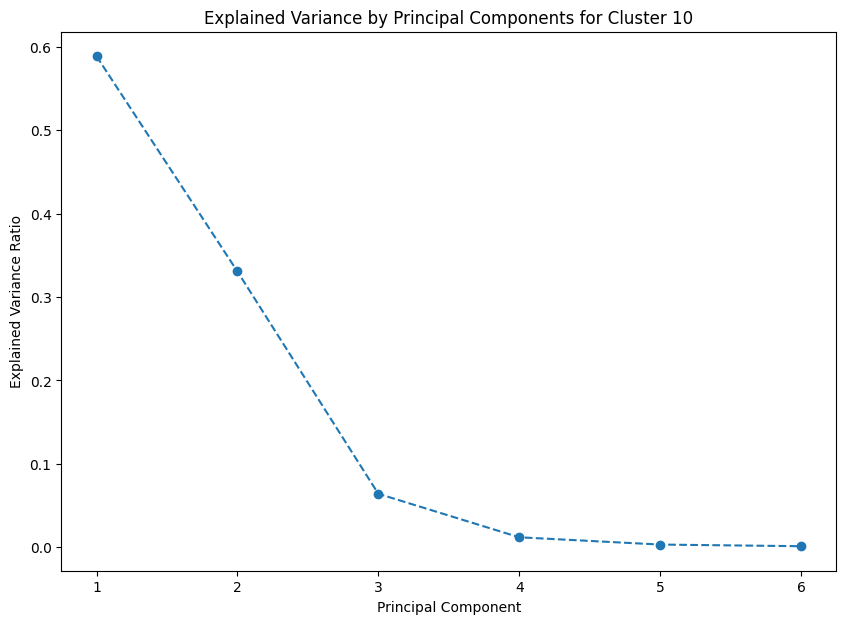

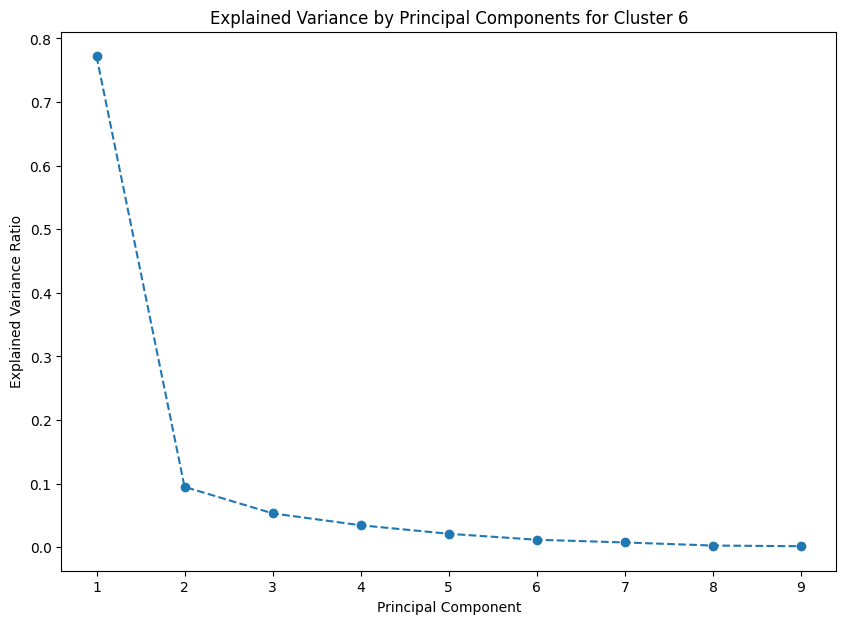

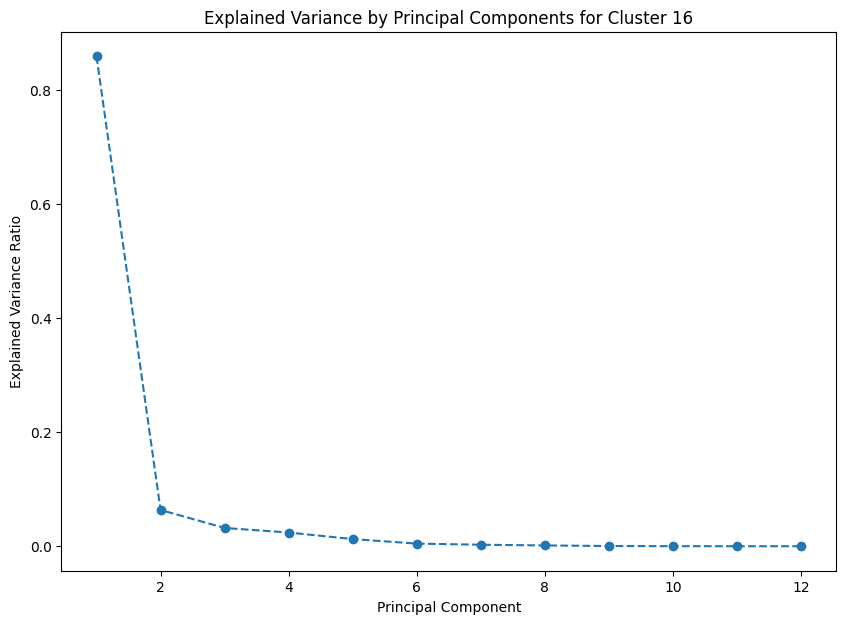

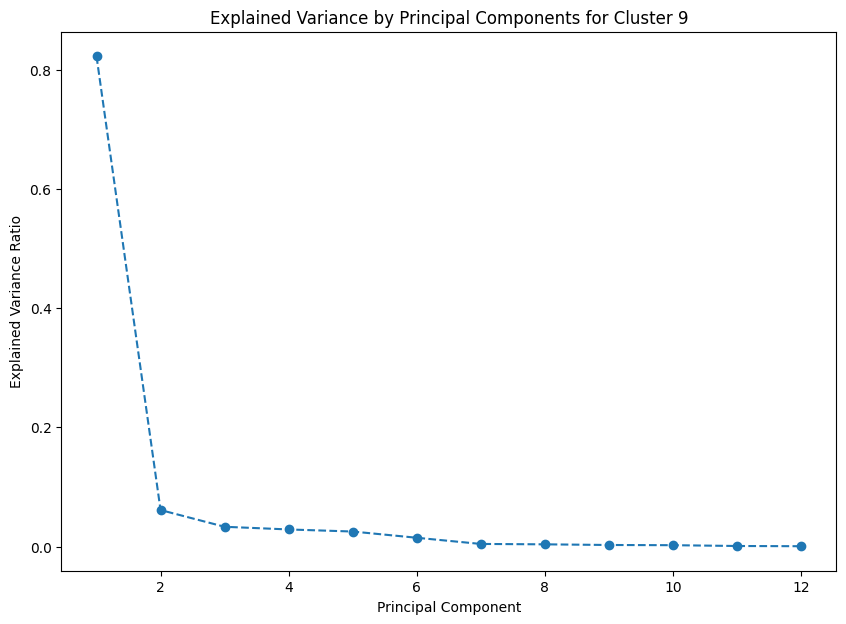

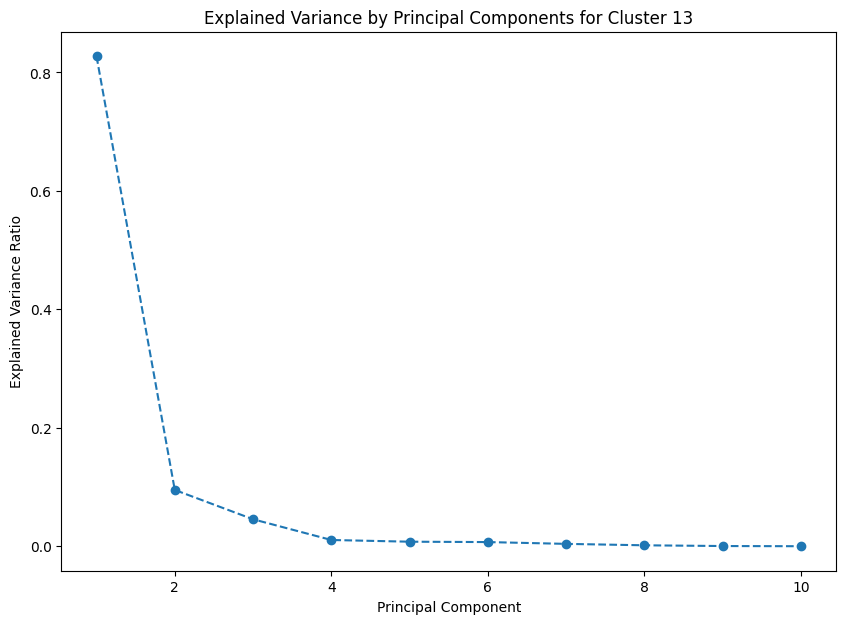

In [9]:
for cluster_id, pca_df in pca_results.items():
    # Perform PCA again to get the explained variance (assuming scaled data was used)
    cluster_variables = cluster_dict[cluster_id]
    cluster_data = df_numeric[cluster_variables]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    pca = PCA().fit(scaled_data)
    
    # Plot explained variance
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
    plt.title(f'Explained Variance by Principal Components for Cluster {cluster_id}')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from itertools import cycle

# Assuming target is already defined as the target column in your dataset
# Combine PCA results with the target column if not already done
# pca_combined['target'] = target.values

# Calculate class counts
class_counts = target.value_counts()
print("Class counts:\n", class_counts)

# Calculate class proportions
class_proportions = class_counts / len(target)
print("\nClass proportions:\n", class_proportions)
# Combine PCA results with the target column
pca_combined['target'] = target.values

# Split the data using stratified sampling
X = pca_combined.drop(columns=['target'])
y = pca_combined['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a RandomForest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Class counts:
 CHC       79
Mixtes    32
CCK       20
Name: classe_name, dtype: int64

Class proportions:
 CHC       0.603053
Mixtes    0.244275
CCK       0.152672
Name: classe_name, dtype: float64
Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

         CCK       0.80      1.00      0.89         4
         CHC       1.00      0.94      0.97        16
      Mixtes       1.00      1.00      1.00         7

    accuracy                           0.96        27
   macro avg       0.93      0.98      0.95        27
weighted avg       0.97      0.96      0.96        27

Confusion Matrix:
[[ 4  0  0]
 [ 1 15  0]
 [ 0  0  7]]


Cross-Validation Accuracy Scores: [0.71428571 0.85714286 0.85714286 0.85714286 0.65      ]
Average Cross-Validation Accuracy: 0.79
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

         CCK       0.75      0.75      0.75         4
         CHC       0.94      0.94      0.94        16
      Mixtes       1.00      1.00      1.00         7

    accuracy                           0.93        27
   macro avg       0.90      0.90      0.90        27
weighted avg       0.93      0.93      0.93        27

Confusion Matrix:
[[ 3  1  0]
 [ 1 15  0]
 [ 0  0  7]]


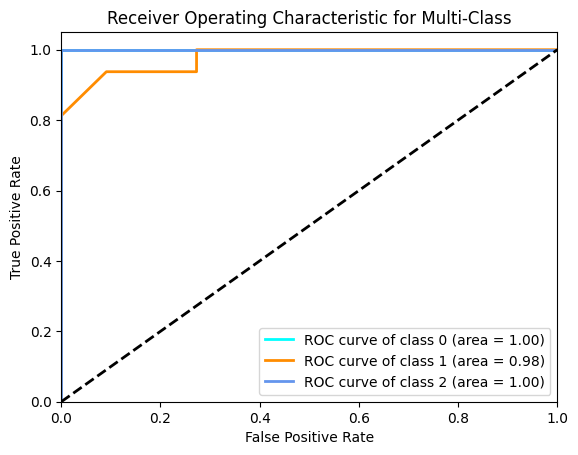

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Assuming pca_combined and target are already defined

# Combine PCA results with the target column
pca_combined['target'] = target.values

# Split the data using stratified sampling
X = pca_combined.drop(columns=['target'])
y = pca_combined['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a RandomForest classifier with cross-validation
model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Average Cross-Validation Accuracy: {cv_scores.mean():.2f}')

# Fit the model on the full training set
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Learn to predict each class against the other
y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = roc_auc_score(y_test_bin, y_score, average="micro")

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest           0.925926   0.933333  0.925926  0.926559  0.984848
Logistic Regression     0.740741   0.737110  0.740741  0.736732  0.922960
Support Vector Machine  0.555556   0.341880  0.555556  0.423280  0.692464
k-Nearest Neighbors     0.592593   0.434783  0.592593  0.499525  0.689752
Gradient Boosting       1.000000   1.000000  1.000000  1.000000  1.000000
Neural Network          0.555556   0.515844  0.555556  0.529346  0.758674
Classifier: Random Forest
Classification Report:
              precision    recall  f1-score   support

         CCK       0.60      0.75      0.67         4
         CHC       0.82      0.88      0.85        16
      Mixtes       1.00      0.71      0.83         7

    accuracy                           0.81        27
   macro avg       0.81      0.78      0.78        27
weighted avg       0.84      0.81      0.82        27

Confusion Matrix:
[[ 3  1  0]
 [ 2 14  0]
 [ 0  2  5

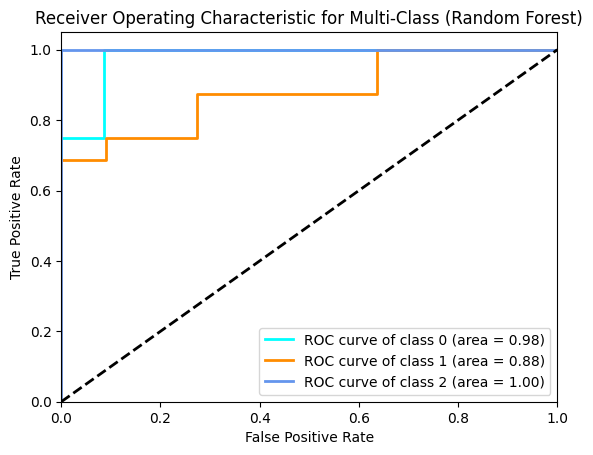

Classifier: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

         CCK       0.67      0.50      0.57         4
         CHC       0.76      0.81      0.79        16
      Mixtes       0.71      0.71      0.71         7

    accuracy                           0.74        27
   macro avg       0.72      0.68      0.69        27
weighted avg       0.74      0.74      0.74        27

Confusion Matrix:
[[ 2  2  0]
 [ 1 13  2]
 [ 0  2  5]]


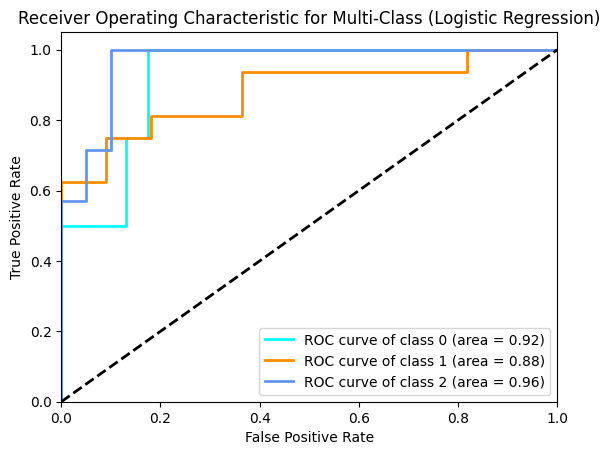

Classifier: Support Vector Machine
Classification Report:
              precision    recall  f1-score   support

         CCK       0.00      0.00      0.00         4
         CHC       0.58      0.94      0.71        16
      Mixtes       0.00      0.00      0.00         7

    accuracy                           0.56        27
   macro avg       0.19      0.31      0.24        27
weighted avg       0.34      0.56      0.42        27

Confusion Matrix:
[[ 0  4  0]
 [ 1 15  0]
 [ 0  7  0]]


/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

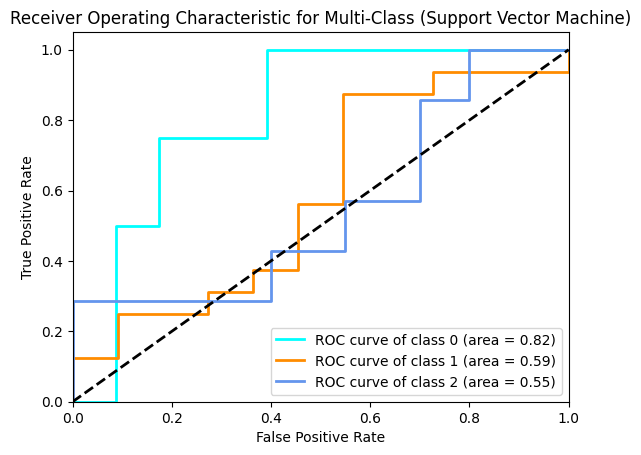

Classifier: k-Nearest Neighbors
Classification Report:
              precision    recall  f1-score   support

         CCK       0.50      0.50      0.50         4
         CHC       0.61      0.88      0.72        16
      Mixtes       0.00      0.00      0.00         7

    accuracy                           0.59        27
   macro avg       0.37      0.46      0.41        27
weighted avg       0.43      0.59      0.50        27

Confusion Matrix:
[[ 2  2  0]
 [ 2 14  0]
 [ 0  7  0]]


/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

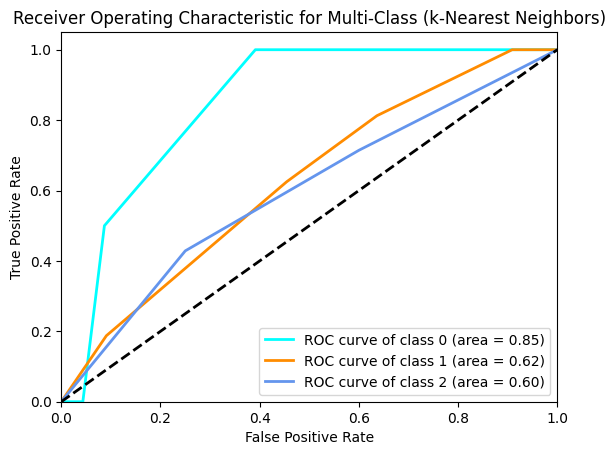

Classifier: Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

         CCK       1.00      1.00      1.00         4
         CHC       1.00      1.00      1.00        16
      Mixtes       1.00      1.00      1.00         7

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

Confusion Matrix:
[[ 4  0  0]
 [ 0 16  0]
 [ 0  0  7]]


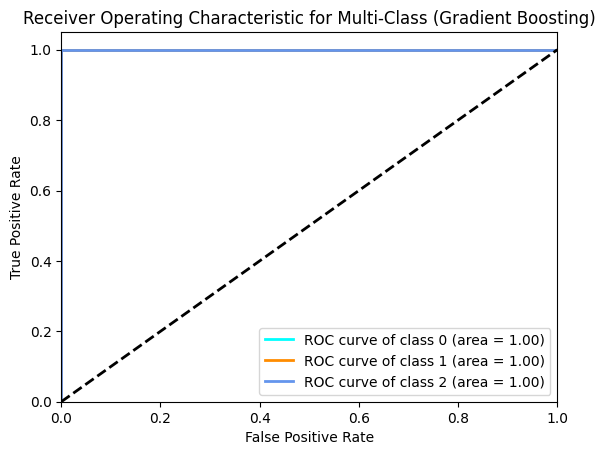

Classifier: Neural Network
Classification Report:
              precision    recall  f1-score   support

         CCK       0.60      0.75      0.67         4
         CHC       0.59      0.62      0.61        16
      Mixtes       0.20      0.14      0.17         7

    accuracy                           0.52        27
   macro avg       0.46      0.51      0.48        27
weighted avg       0.49      0.52      0.50        27

Confusion Matrix:
[[ 3  1  0]
 [ 2 10  4]
 [ 0  6  1]]


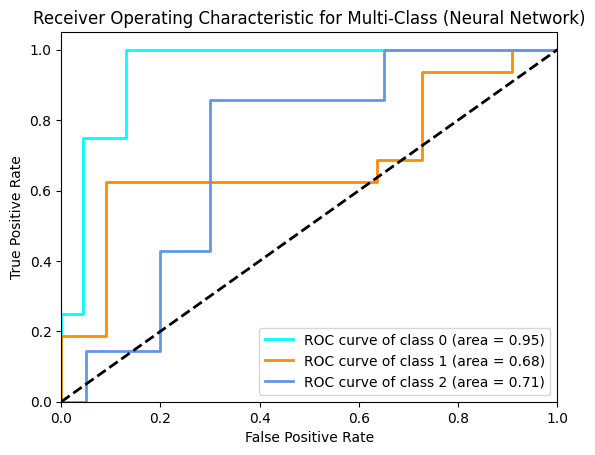

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Load and preprocess the data
# Assume pca_combined and target are already defined

# Combine PCA results with the target column
pca_combined['target'] = target.values

# Split the data using stratified sampling
X = pca_combined.drop(columns=['target'])
y = pca_combined['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# List of classifiers with multi-class strategy specified where needed
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "Support Vector Machine": SVC(probability=True, decision_function_shape='ovr'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Function to evaluate and compare classifiers
def evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers):
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Check if the classifier supports predict_proba
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)
            if len(y_proba.shape) > 1 and y_proba.shape[1] > 1:  # Multi-class case
                roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            else:  # Binary classification case
                roc_auc = roc_auc_score(y_test, y_proba[:, 1])
        else:
            roc_auc = None
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        }
    
    return pd.DataFrame(results).T

# Evaluate and compare classifiers
results = evaluate_classifiers(X_train, X_test, y_train, y_test, classifiers)
print(results)

# Generate detailed classification report for each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classifier: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # If classifier supports predict_proba, plot the ROC curve for each class
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        n_classes = y_test_bin.shape[1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

        # Plot ROC curve for each class
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for Multi-Class ({name})')
        plt.legend(loc="lower right")
        plt.show()

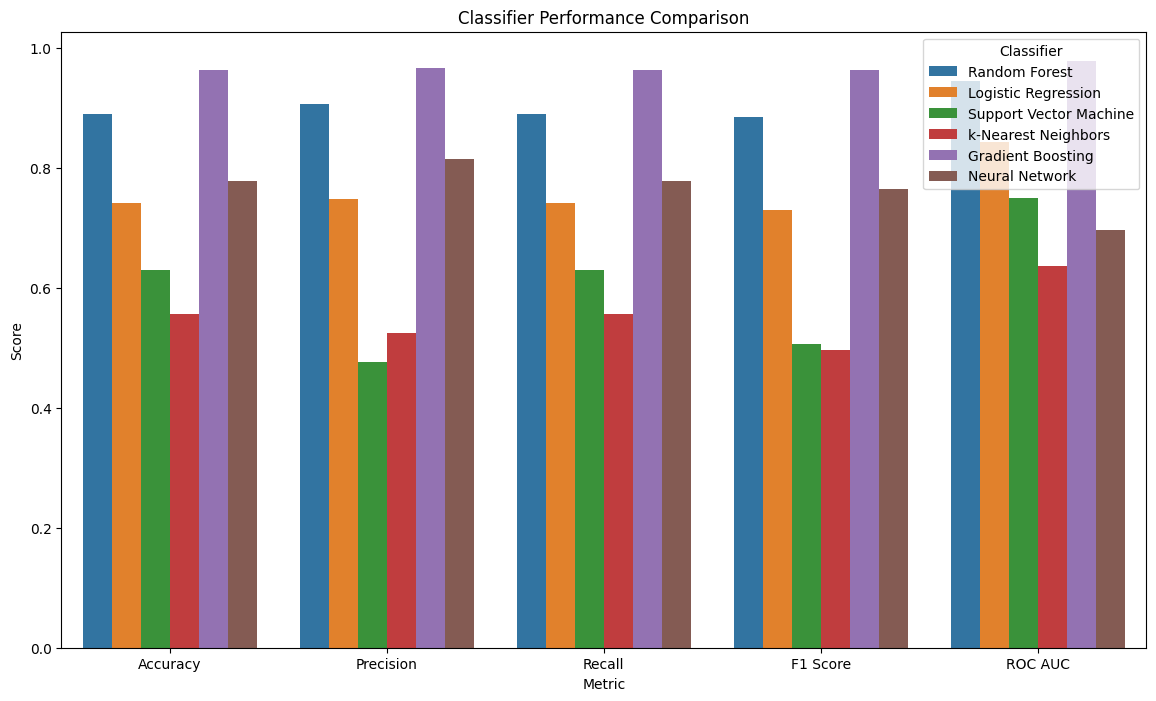

In [12]:
# Visualize the results
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
results_plot = results[metrics].reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
plt.figure(figsize=(14, 8))
sns.barplot(x="Metric", y="Score", hue="index", data=results_plot)
plt.title("Classifier Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Classifier")
plt.show()